对效果最好的模型进行全面的测试

In [1]:
import sys
sys.path.append('..')

In [2]:
from py_file.M_attri import Att
from py_file.Get_Data import DATA
from py_file.data_set import MyDataSet
from torch.utils.data import DataLoader,Dataset,random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [3]:
trans = transforms.Resize(224)  # ResNet模型适合的图片大小为224x244
# 输入的张量需要带着批次维度和通道维度

# 准备模型以及数据

In [4]:
# 由于未更新的模型和语义效果更好，我们采用未更新的
# 读取模型以及语义属性
import pickle
# model = torch.load('model_saved_pseudo/all_updated.pth')
model = torch.load('model_saved_pseudo/train_all.pth')
model.eval()
'''
attri = Att()
attri.compute_mul_defect_att()

single_defect_att = attri.single_defect_att
two_defect_att = attri.two_defect_att
three_defect_att = attri.three_defect_att
four_defect_att = attri.four_defect_att
mul_defect_att = attri.mul_defect_att
total_defect_att = attri.total_defect_att
'''
with open('updated_semantic_all/updated_single_dict.pkl', 'rb') as file:
    single_defect_att = pickle.load(file)
with open('updated_semantic_all/updated_mul_dict.pkl', 'rb') as file:
    mul_defect_att = pickle.load(file)
with open('updated_semantic_all/updated_total_dict.pkl', 'rb') as file:
    total_defect_att = pickle.load(file)

from collections import Counter
# 加载二、三、四缺陷的字典
two_defect_att = {}
three_defect_att = {}
four_defect_att = {}
for label in mul_defect_att.keys():
    count = Counter(label)
    if count['+'] == 1:
        two_defect_att[label] = mul_defect_att[label]
    if count['+'] == 2:
        three_defect_att[label] = mul_defect_att[label]
    if count['+'] == 3:
        four_defect_att[label] = mul_defect_att[label]

In [5]:
test_data_path = '../DATA/test_WM.npz'
test_data = np.load(test_data_path)

att_dimen = len(single_defect_att['Center'])
print('att_dimen:', att_dimen)

att_dimen: 20


In [6]:
# 把标签转换为对应的属性向量
test_label = test_data['label_name']
test_att_vector = []
for l in test_data['label_name']:
    test_att_vector.append(total_defect_att[l])

test_att_vector = np.array(test_att_vector)

In [7]:
test_wm = test_data['denoise_wm']
test_wm_tensor = torch.reshape(torch.tensor(test_wm, dtype=torch.float32),(len(test_wm),1,52,52))
test_wm_tensor = trans(test_wm_tensor)
test_att_tensor = torch.tensor(test_att_vector, dtype=torch.float32)

print(test_wm_tensor.shape, test_att_tensor.shape)

torch.Size([7405, 1, 224, 224]) torch.Size([7405, 20])


In [8]:
test_label_oh = test_data['label_one_hot']
# 通过one_hot标签给数据分为单缺陷、双缺陷、三缺陷以及四缺陷

test_single_wm = []  # 先定义列表，然后转换为tensor
test_single_label = []
test_single_att = []

test_two_wm = []
test_two_label = []
test_two_att = []

test_three_wm = []
test_three_label = []
test_three_att = []

test_four_wm = []
test_four_label = []
test_four_att = []
for i in range(len(test_label_oh)):
    if test_label_oh[i].sum() <= 1:
        test_single_wm.append(np.array(test_wm_tensor[i]))
        test_single_label.append(test_label[i])
        test_single_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 2:
        test_two_wm.append(np.array(test_wm_tensor[i]))
        test_two_label.append(test_label[i])
        test_two_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 3:
        test_three_wm.append(np.array(test_wm_tensor[i]))
        test_three_label.append(test_label[i])
        test_three_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 4:
        test_four_wm.append(np.array(test_wm_tensor[i]))
        test_four_label.append(test_label[i])
        test_four_att.append(np.array(test_att_tensor[i]))

del test_data

# 开始测试

In [9]:
from py_file.func_Test import Test_Func
# 需要的函数都已经集成在了Test_Func里
func = Test_Func()

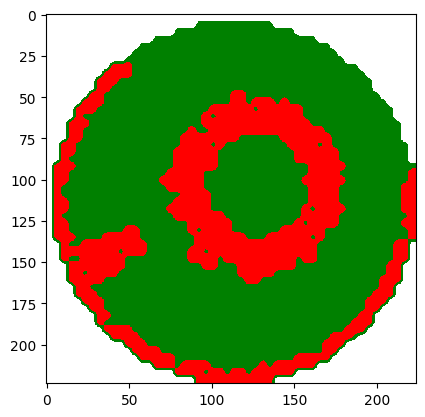

预测的属性向量tensor([-0.0260,  1.0804,  0.4723,  0.4233,  1.0267,  1.0064,  1.1229,  0.9413,
         0.4122, -0.0101, -0.0146,  0.0158,  0.1366,  0.8129,  0.1127,  0.8396,
         1.1114,  0.9418,  0.1214,  0.9499], device='cuda:0')
真实的属性向量tensor([ 0.0405,  1.0156,  0.8555,  0.7538,  1.1116,  1.0811,  1.0587,  0.9717,
         0.8082, -0.0273, -0.0235, -0.0309,  0.1744,  1.0708,  0.2163,  1.0599,
         1.0693,  0.9846,  0.2035,  1.1908])
真实标签为：D+EL+L
欧式距离计算的标签为：D+EL
余弦相似度计算的标签为：D+EL


In [10]:
func.show_result(model, test_wm_tensor, test_att_tensor, total_defect_att)

## 所有样本

In [11]:
all_dataset = MyDataSet(test_wm_tensor, test_att_tensor)
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=False)
del test_wm_tensor, test_att_tensor

In [12]:
# 不使用校准堆叠
print(func.get_acc(model, all_loader, total_defect_att, len(all_dataset), 'cos'))

0.7531397704253883


In [18]:
# 使用校准堆叠
print(func.get_acc(model, all_loader, total_defect_att, len(all_dataset), 'cos', 1, 0.04))

0.7563808237677245


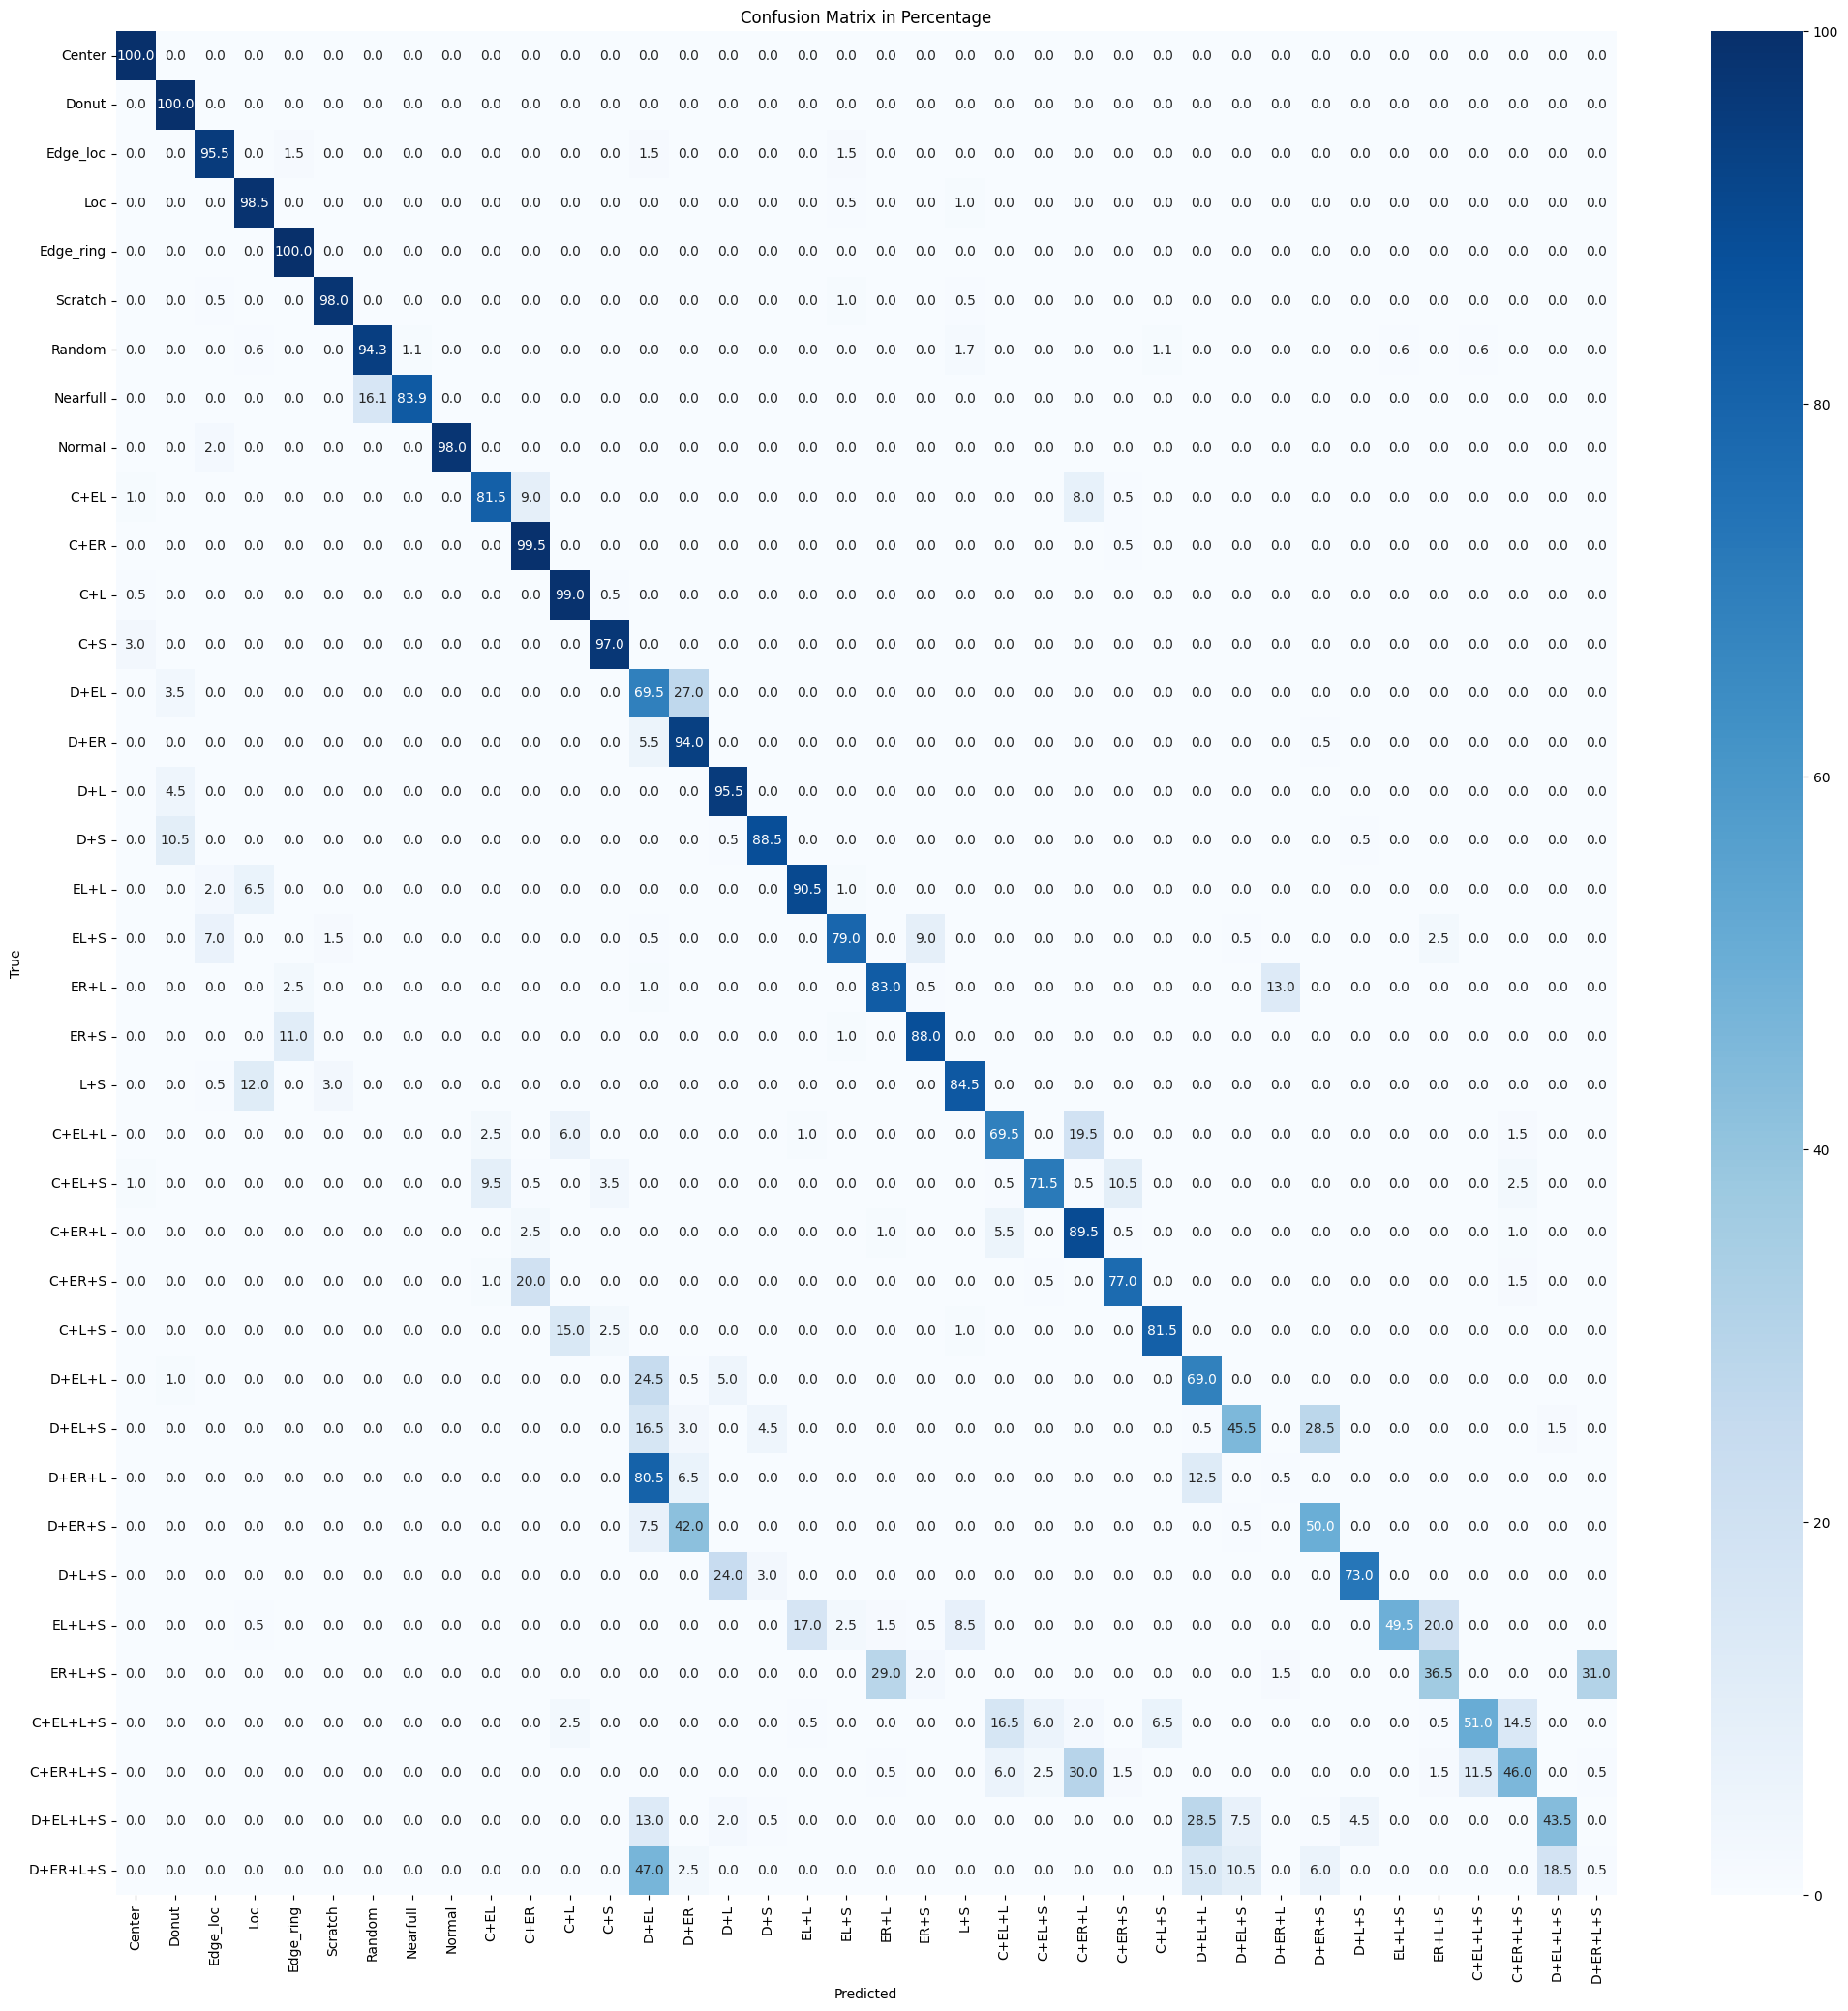

In [19]:
# 展示不使用校准堆叠，cos度量的混淆矩阵
true_label,pre_label = func.get_label(model, all_loader, total_defect_att, 'cos')
label_order = list(total_defect_att.keys())
func.show_cm(true_label,pre_label,label_order,'per',25)

In [20]:
del all_dataset,all_loader

## 混合故障

In [21]:
test_mul_wm = test_two_wm + test_three_wm + test_four_wm
test_mul_att = test_two_att + test_three_att + test_four_att

mul_defect_att = {**two_defect_att, **three_defect_att, **four_defect_att}

In [22]:
test_mul_wm_tensor = torch.tensor(np.array(test_mul_wm), dtype=torch.float32)
test_mul_att_tensor = torch.tensor(np.array(test_mul_att), dtype=torch.float32)
del test_mul_wm, test_mul_att

mul_dataset = MyDataSet(test_mul_wm_tensor, test_mul_att_tensor)
mul_loader = DataLoader(mul_dataset, batch_size=32, shuffle=False)
del test_mul_wm_tensor, test_mul_att_tensor

### 狭义搜索

In [23]:
# 在各自缺陷级别的搜索空间中的准确率
print(func.get_acc(model, mul_loader, mul_defect_att, len(mul_dataset), 'cos'))

0.7067241379310345


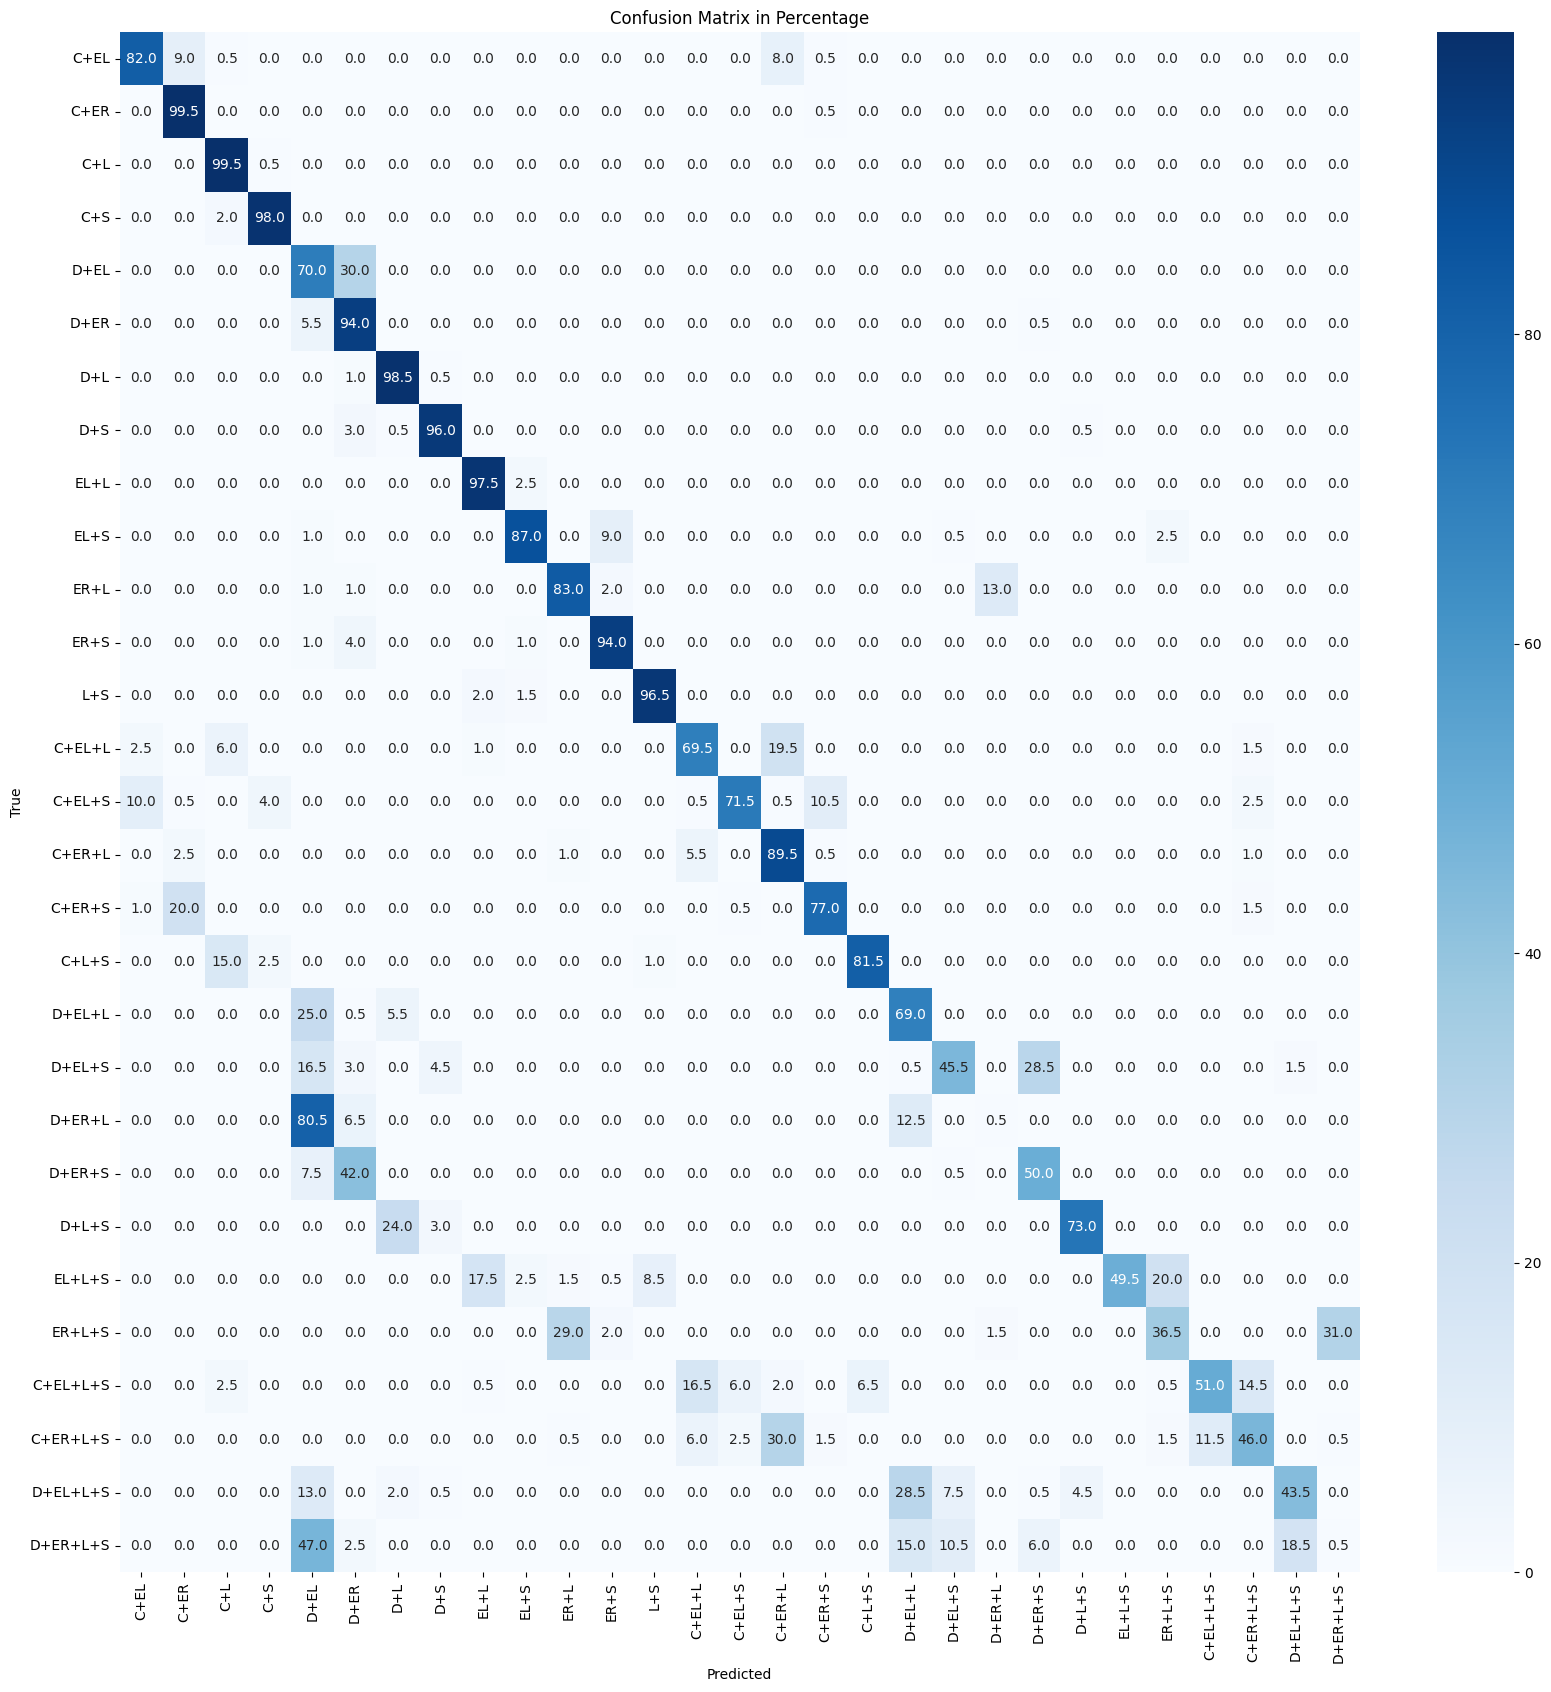

In [24]:
# cos度量的混淆矩阵
true_label,pre_label = func.get_label(model, mul_loader, mul_defect_att, 'cos')
label_order = list(mul_defect_att.keys())
func.show_cm(true_label,pre_label,label_order,'per',20)

### 广义搜索

In [25]:
# 在包含全部缺陷类别的搜索空间中的准确率
print(func.get_acc(model, mul_loader, total_defect_att, len(mul_dataset), 'cos'))

0.6908620689655173


In [26]:
del mul_dataset, mul_loader

## 单故障

In [27]:
test_single_wm_tensor = torch.tensor(np.array(test_single_wm), dtype=torch.float32)
test_single_att_tensor = torch.tensor(np.array(test_single_att), dtype=torch.float32)
del test_single_wm, test_single_att

single_dataset = MyDataSet(test_single_wm_tensor, test_single_att_tensor)
single_loader = DataLoader(single_dataset, batch_size=32, shuffle=False)
del test_single_wm_tensor, test_single_att_tensor

### 狭义搜索

In [28]:
# 在各自缺陷级别的搜索空间中的准确率
print(func.get_acc(model, single_loader, single_defect_att, len(single_dataset), 'cos'))

0.983177570093458


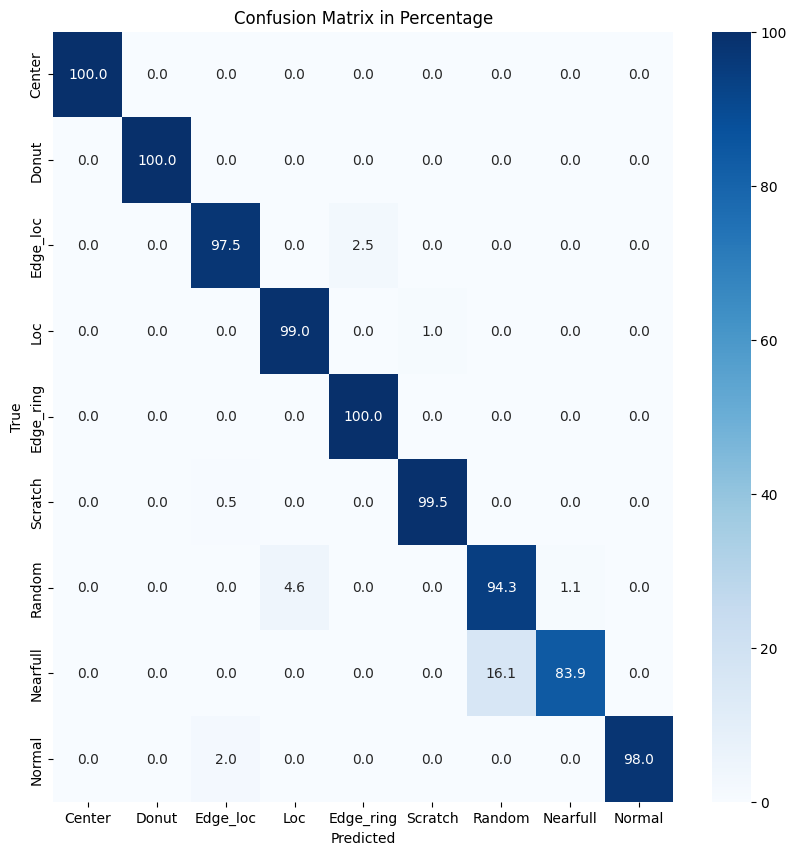

In [29]:
# cos度量的混淆矩阵
true_label,pre_label = func.get_label(model, single_loader, single_defect_att, 'cos')
label_order = list(single_defect_att.keys())
func.show_cm(true_label,pre_label,label_order,'per',10)

### 广义搜索

In [30]:
# 在包含全部缺陷类别的搜索空间中的准确率
print(func.get_acc(model, single_loader, total_defect_att, len(single_dataset), 'cos'))

0.9781931464174455


In [31]:
del single_dataset, single_loader

## 双故障

In [10]:
test_two_wm_tensor = torch.tensor(np.array(test_two_wm), dtype=torch.float32)
test_two_att_tensor = torch.tensor(np.array(test_two_att), dtype=torch.float32)
del test_two_wm, test_two_att

two_dataset = MyDataSet(test_two_wm_tensor, test_two_att_tensor)
two_loader = DataLoader(two_dataset, batch_size=32, shuffle=False)
del test_two_wm_tensor, test_two_att_tensor

### 狭义搜索

In [11]:
# 在各自缺陷级别的搜索空间中的准确率
print(func.get_acc(model, two_loader, two_defect_att, len(two_dataset), 'cos'))

0.9342307692307692


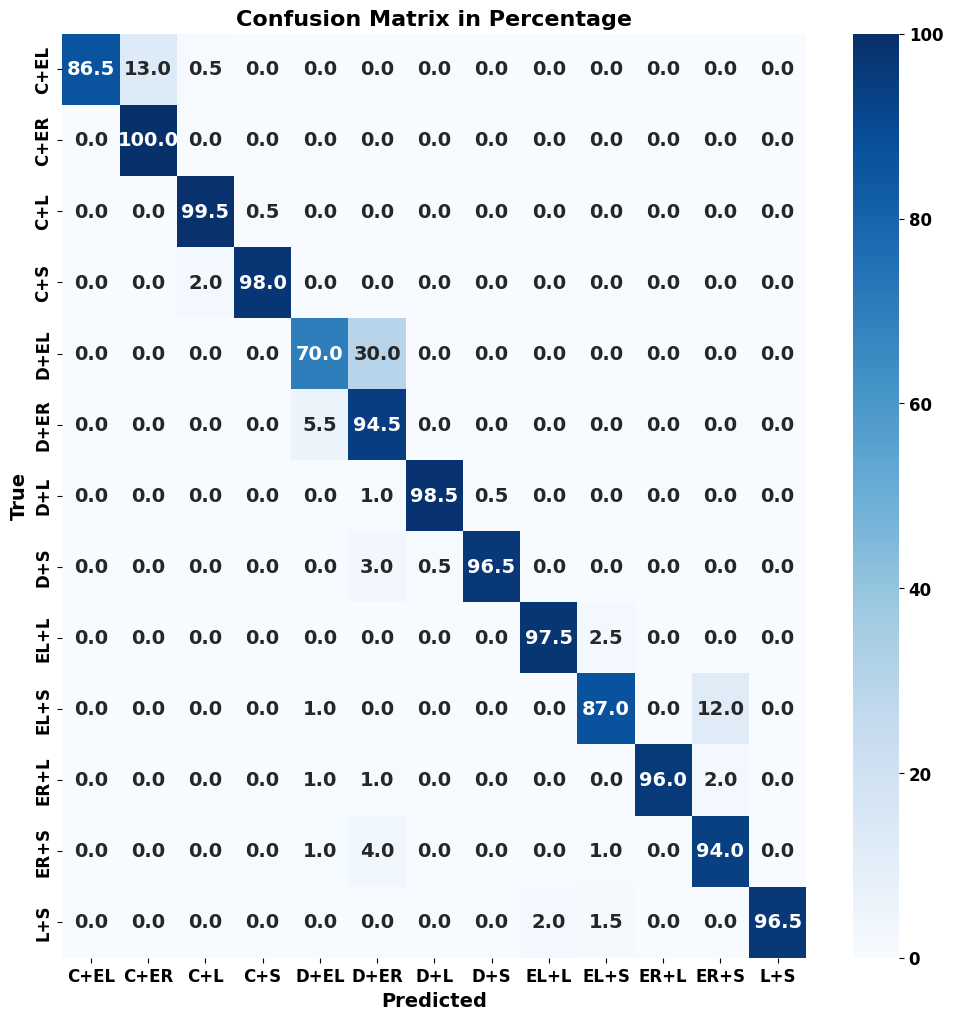

In [13]:
# cos度量的混淆矩阵
true_label,pre_label = func.get_label(model, two_loader, two_defect_att, 'cos')
label_order = list(two_defect_att.keys())
func.show_cm2(true_label,pre_label,label_order,'per',12)

### 广义搜索

In [35]:
# 在包含全部缺陷类别的搜索空间中的准确率
print(func.get_acc(model, two_loader, total_defect_att, len(two_dataset), 'cos'))

0.8842307692307693


In [36]:
del two_dataset, two_loader

## 三故障

In [37]:
test_three_wm_tensor = torch.tensor(np.array(test_three_wm), dtype=torch.float32)
test_three_att_tensor = torch.tensor(np.array(test_three_att), dtype=torch.float32)
del test_three_wm, test_three_att

three_dataset = MyDataSet(test_three_wm_tensor, test_three_att_tensor)
three_loader = DataLoader(three_dataset, batch_size=32, shuffle=False)
del test_three_wm_tensor, test_three_att_tensor

### 狭义搜索

In [38]:
# 在各自缺陷级别的搜索空间中的准确率
print(func.get_acc(model, three_loader, three_defect_att, len(three_dataset), 'cos'))

0.77875


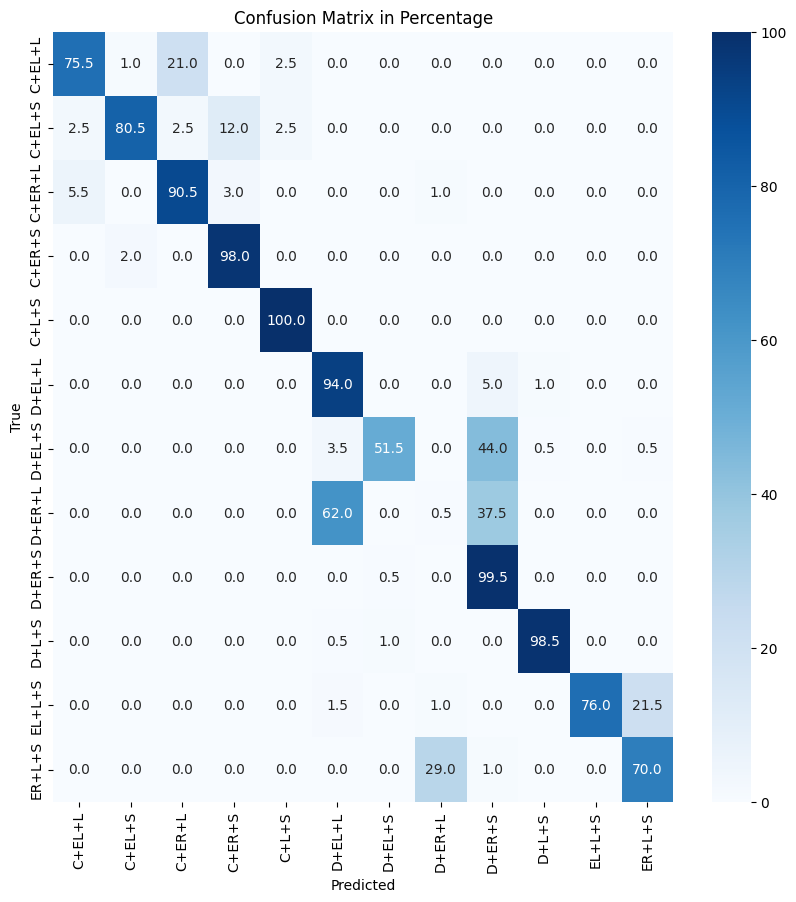

In [39]:
# cos度量的混淆矩阵
true_label,pre_label = func.get_label(model, three_loader, three_defect_att, 'cos')
label_order = list(three_defect_att.keys())
func.show_cm(true_label,pre_label,label_order,'per',10)

### 广义搜索

In [40]:
# 在包含全部缺陷类别的搜索空间中的准确率
print(func.get_acc(model, three_loader, total_defect_att, len(three_dataset), 'cos'))

0.5941666666666666


In [41]:
del three_dataset, three_loader

## 四故障

In [42]:
test_four_wm_tensor = torch.tensor(np.array(test_four_wm), dtype=torch.float32)
test_four_att_tensor = torch.tensor(np.array(test_four_att), dtype=torch.float32)
del test_four_wm, test_four_att

four_dataset = MyDataSet(test_four_wm_tensor, test_four_att_tensor)
four_loader = DataLoader(four_dataset, batch_size=32, shuffle=False)
del test_four_wm_tensor, test_four_att_tensor

### 狭义搜索

In [43]:
# 在各自缺陷级别的搜索空间中的准确率
print(func.get_acc(model, four_loader, four_defect_att, len(four_dataset), 'cos'))

0.71875


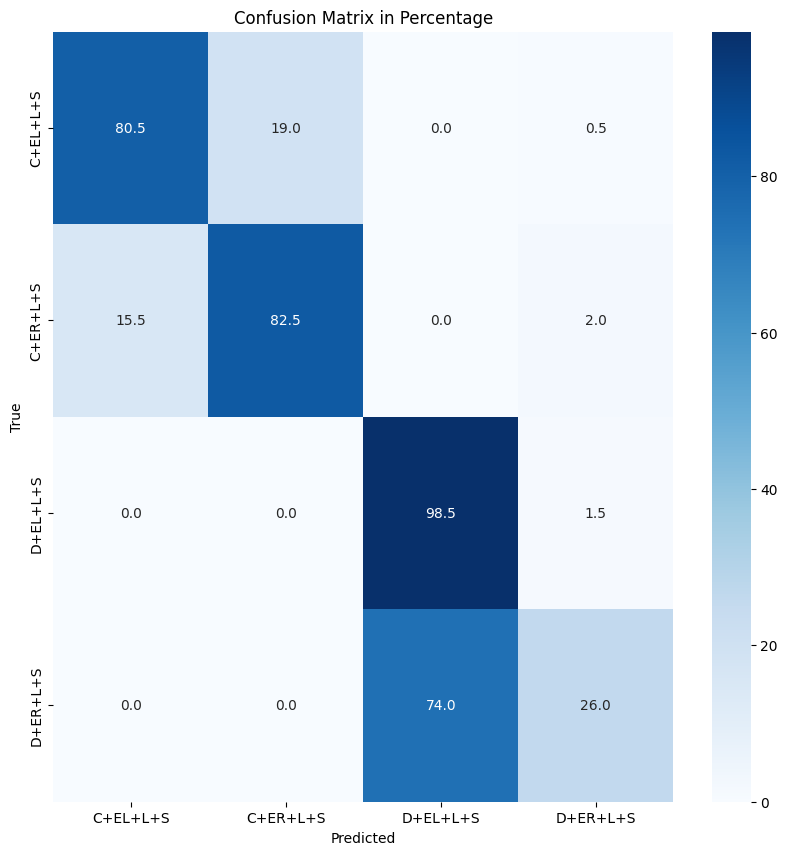

In [44]:
# cos度量的混淆矩阵
true_label,pre_label = func.get_label(model, four_loader, four_defect_att, 'cos')
label_order = list(four_defect_att.keys())
func.show_cm(true_label,pre_label,label_order,'per',10)

### 广义搜索

In [45]:
# 在包含全部缺陷类别的搜索空间中的准确率
print(func.get_acc(model, four_loader, total_defect_att, len(four_dataset), 'cos'))

0.3525


In [46]:
del four_dataset, four_loader